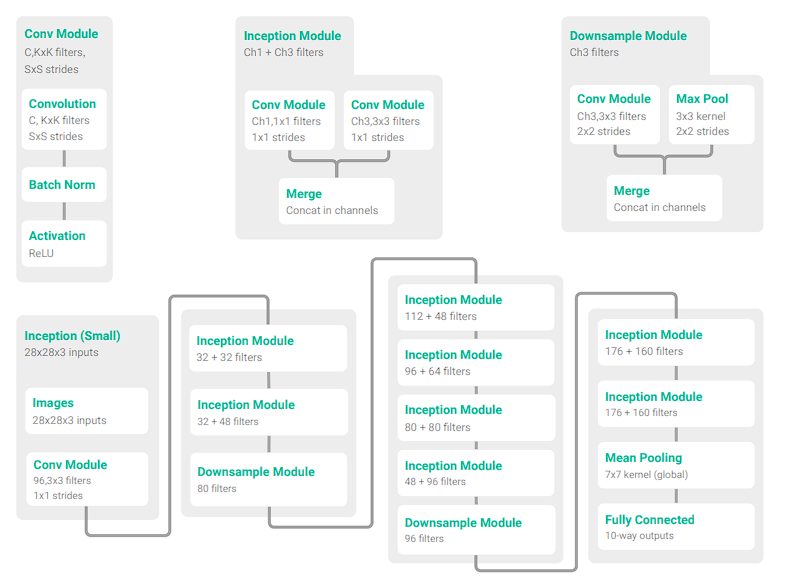

In [61]:
#imports

import torch
import torch.nn as nn
import torch.optim as optim
from torch .utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import time
import numpy as numpy
import matplotlib.pyplot as pyplot
import random

In [62]:
#params

input_channels = 3
num_classes = 10

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # Use the first available GPU
    print("using GPU")
else:
    device = torch.device("cpu")
    print("using CPU")
lr = 1e-2
epochs = 80
batch_size = 16

using CPU


In [63]:
#create list of commands for transforming the image

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(28)
])

#create a function that normalizes each image

def norm_image(data_sample):
    img_tensor = data_sample[0]
    label = data_sample[1]
    
    img_means = img_tensor.mean(axis=[1,2])
    img_sds = img_tensor.std(axis=[1,2])
    
    mean_sub = img_tensor - img_means.unsqueeze(1).unsqueeze(2)
    img_norm = mean_sub.true_divide(img_sds.unsqueeze(1).unsqueeze(2))
    
    return (img_norm, label)

In [64]:
#training set

all_train =list(datasets.CIFAR10(root = 'data/', transform = img_transform, train=True, download=True ))

random.shuffle(all_train)

train_data = all_train[:40000]
train_transformed = list(map(norm_image, train_data))
train_loader = DataLoader(dataset=train_transformed, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [65]:
#get a validation set of 10,000 images

val_data = all_train[40000:]
val_transformed = list(map(norm_image, val_data))
val_loader = DataLoader(dataset=val_transformed, batch_size=batch_size, shuffle=True)

In [66]:
#test data

test_data = datasets.CIFAR10(root='data/',transform = img_transform, train=False, download=True)
test_tranformed = list(map(norm_image, test_data))
test_loader = DataLoader(dataset=test_tranformed, batch_size=batch_size)

Files already downloaded and verified


In [67]:
#create a class for the convolutional module

class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(conv_block, self).__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x

In [68]:
#create a class for the inception block

class inception_block(nn.Module):
    def __init__(self, in_channels, out_ch1, out_ch3):
        super(inception_block, self).__init__()
        self.ch1 = conv_block(in_channels=in_channels, out_channels=out_ch1, kernel_size=(3,3), stride=(1,1), padding='same')
        self.ch3 = conv_block(in_channels=in_channels, out_channels=out_ch3, kernel_size=(3,3), stride=(1,1), padding='same')
        
    def forward(self, x):
        return torch.cat([self.ch1(x),self.ch3(x)], 1)
     

In [69]:
#create a class for the downsample module

class downsample_block(nn.Module):
    def __init__(self, in_channels, conv_out):
        super(downsample_block, self).__init__()
        self.convblock = conv_block(in_channels, conv_out, kernel_size=(3,3), stride=(2,2))
        self.maxpool = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2))
        
    def forward(self, x):
        return torch.cat([self.convblock(x), self.maxpool(x)], 1)
        

In [70]:
#put the mini GoogLeNet together

class mini_GoogLeNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=10, dropout_prob=0):
        super(mini_GoogLeNet, self).__init__()
        self.conv1 = conv_block(in_channels=3, out_channels=96, kernel_size=(3,3), stride=(1,1))
        self.inception1 = inception_block(96, 32, 32)
        self.inception2 = inception_block(64, 32, 48)
        self.downsample1 = downsample_block(80, 80)
        self.inception3 = inception_block(160, 112, 48)
        self.inception4 = inception_block(160, 96, 64)
        self.inception5 = inception_block(160, 80, 80)
        self.inception6 = inception_block(160, 48, 96)
        self.downsample2 = downsample_block(144, 96)
        self.inception7 = inception_block(240, 176, 160)
        self.inception8 = inception_block(336, 176, 160)
        self.avgpool = nn.AvgPool2d(kernel_size=(7,7), padding=(1,1))
        self.dropout = nn.Dropout(p = dropout_prob)
        self.fc = nn.Linear(336, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.downsample1(x)
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.downsample2(x)
        x = self.inception7(x)
        x = self.inception8(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0],-1)
        x = self.dropout(x)
        x = self.fc(x)
        return x
        

In [71]:
#model training

model = mini_GoogLeNet(in_channels=3, num_classes=10, dropout_prob=0).to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.LinearLR(optimizer)

def train(epoch):
    model.train()
    curr_loss_train = 0
    correct_train = 0
    total_train = 0
    
    for ind, (data_train, true_labels_train) in enumerate(train_loader):
        data_train = data_train.to(device=device)
        true_labels_train - true_labels_train.to(device=device)
        
        out_train = model(data_train)
        loss_train = loss_function(out_train, true_labels_train)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        curr_loss_train += loss_train.item()
        ix, predicted_train = out_train.max(1)
        correct_train += predicted_train.eq(true_labels_train).sum().item()
        total_train += true_labels_train.size(0)
        
        train_loss = curr_loss_train/len(train_loader)
        acc_train_val = (correct_train/total_train)*100
        
        train_acc.append(acc_train_val)
        train_all_loss.append(train_loss)

def test(epoch):
    model.eval()
    curr_loss_test = 0
    correct_test = 0
    total_test = 0
    
    num_class = 10
    confusion_matrix = torch.zeros(num_class, num_class)
    with torch.no_grad():
       for data_test, true_labels_test in test_loader:
           
           data_test = data_test.to(device=device)
           true_labels_test = true_labels_test.to(device=device)
           
           out_test = model(data_test)
           loss_test = loss_function(out_test, true_labels_test)
           
           curr_loss_test += loss_test.item()
           ix, predicted_test = out_test.max(1)
           correct_test += predicted_test.eq(true_labels_test).sum().item()
           total_test += true_labels_test.size(0)
           
           for tr, pr in zip(true_labels_test.view(-1), predicted_test.view(-1)):
               confusion_matrix[tr.long(), pr.long()] += 1
               
    test_loss = curr_loss_test/len(test_loader)
    acc_test_val = (correct_test/total_test)*100
    
    test_acc.append(acc_test_val)
    test_all_loss.append(test_loss)
    con_mats.append(confusion_matrix)            

In [72]:
#get metrics

train_acc = []
train_all_loss = []
test_acc = []
test_all_loss = []
con_mats = []
times = []

train_start = time.time()
for epoch in range(epochs):
    ep_start = time.time()
    print(epoch)
    train(epoch)
    test(epoch)
    scheduler.step()
    
    epoch_time = time.time() - ep_start
    print(epoch_time)
    times.append(epoch_time)

train_time = time.time() - train_start

print(f'run time: {train_time}')


0
517.5832374095917
1
510.745450258255
2
514.6313638687134
3
511.7551758289337
4
506.58213543891907
5
502.6249599456787
6
510.48647379875183
7
530.9853811264038
8
553.233021736145
9
552.9643273353577
10
419.0088801383972
11
392.053747177124
12
391.23864579200745
13
390.63020849227905
14
387.66308665275574
15
397.7704086303711
16
324.19802165031433
17
355.19731736183167
18
363.0716428756714
19
359.3259265422821
20
359.0157527923584
21
369.9601502418518
22
493.3022086620331
23
534.3781681060791
24
531.0070357322693
25
524.2808640003204
26
524.6209418773651
27
524.3361458778381
28
403.78552412986755
29
385.6424102783203
30
535.2599613666534
31
535.2908890247345
32
363.83688521385193
33
353.0151906013489
34
352.6734211444855
35
357.26223134994507
36
370.7439081668854
37
364.47412157058716
38
364.45969796180725
39
357.72994470596313
40
359.4139835834503
41
357.59532833099365
42
359.357417345047
43
358.19318199157715
44
354.035831451416
45
421.9173529148102
46
509.7697308063507
47
540.409026